# SiPM Showers

#### 1) Select events using a run's DST file -- > 2) Look at those events' waveforms

Here, I use this notebook to look at the waveforms of sodium events near the photoelectric peak

In [1]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-04-25 12:53:51


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import time
import tables as tb
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from invisible_cities.database import load_db
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.params import S12Params, ThresholdParams
from   invisible_cities.core.system_of_units_c import units
from invisible_cities.core.core_functions import in_range
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.reco.pmaps_functions import plot_s12

sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')
from icaro.core.event_pmaps     import EventPmaps, print_s12, print_s2si
from icaro.core.kdst_functions  import load_dst, event_rate, profile_and_fit, print_fit, chi2
from icaro.core.hst_functions   import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                                     doublescatter, covariance, reso, gausstext, plot_profile_histogram 

### Run Parameters

In [9]:
run_number =  3741

# consecutive! could do a little more work and make them not have to be consecutive
subruns     = ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009']

In [10]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [160]:
ext_t = 170 * units.mm
ext_sipms = np.array(list(set(np.where(xs > ext_t)[0]) | set(np.where(ys > ext_t)[0])), 
                     dtype=np.int32)



In [165]:
for sipm in ext_sipms:
    if xs[sipm] < ext_t and ys[sipm] < ext_t: print('Broken')
print(len(ext_sipms))

328


### 1) HAVE ACCESS TO WVFMS FROM CONSECTIVE SUBRUNS

In [11]:
## consecutive meaning subrun 025, 026, 027... for ex

RWF_path = os.path.join(os.environ['IC_DATA'], 'LSC/wvfms/{}/'.format(run_number))
RWF_files = [RWF_path + 'dst_waves.gdcsnext.{}_{}.root.h5'.format(subrun, run_number) for subrun in subruns]
print(RWF_files)

['/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.000_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.001_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.002_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.003_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.004_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.005_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.006_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.007_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.008_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.009_3741.root.h5']


### 2) FIND STARTING AND FINAL EVENT IN THESE SUBRUNS

In [12]:
startfile = tb.open_file(RWF_files[0],'r')
sev = startfile.root.Run.events[0][0]
startfile.close()

endfile = tb.open_file(RWF_files[-1],'r')
fev = endfile.root.Run.events[-1][0]
endfile.close()
print('These subruns include events in this (inclusive) range: ')
print(sev, fev)

These subruns include events in this (inclusive) range: 
1 1680


In [13]:
ifile = os.path.join(os.environ['IC_DATA'],
                        'LSC/kdst/{}/dst_{}.root.h5'.format(run_number,run_number))
print("ifile:", ifile)
full = load_dst(ifile)

ifile: /Users/alej/Desktop/IC_DATA/LSC/kdst/3741/dst_3741.root.h5


## 3) Select events in dst

In [14]:
srs  = full[in_range(full.event, sev, fev)]
srsc = srs[srs.nS2==1]

print(len(srs), len(srsc))

1149 1149


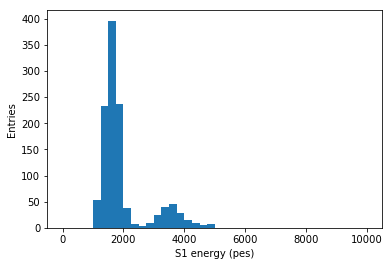

In [15]:
hist(srs.S1e, 40, (0,10000))
labels("S1 energy (pes)", "Entries")

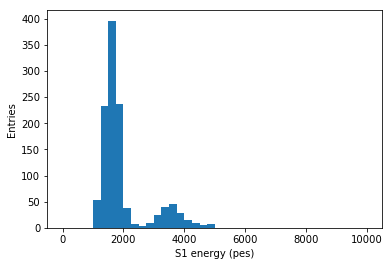

In [16]:
hist(srsc.S1e, 40, (0,10000))
labels("S1 energy (pes)", "Entries")

In [20]:
print(spmtrwf.shape)
print(ssipmrwf.shape)

(98, 12, 52000)
(98, 1792, 1300)


In [61]:
s1par  = S12Params(tmin=  0*units.mus, tmax=649*units.mus, lmin=5, lmax=30, stride=4, rebin=False)
s2par = S12Params( tmin=649*units.mus, tmax=700*units.mus, stride=80, lmin=80, lmax=20000, rebin=True)
thr    = ThresholdParams(thr_s1=3 * units.pes,  thr_s2=1*units.pes,
                        thr_MAU = 3 * units.adc, thr_sipm = .5 * units.pes,
                        thr_SIPM = 30 * units.adc)
epm = EventPmaps(run_number, s1par, s2par, thr, verbose=False)

In [ ]:
MEVTS = 

#Aswf = np.zeros((1792, 700,), dtype=np.float32)
Bswf = np.zeros((1792, 700,), dtype=np.float32)

#Apes = []
Bpes = []
Bspes = []
Bfpes = []
#At = []
Bt = []

Bext_pes = []
Bint_pes = []

pevts = 0
for subrun in RWF_files:
    if pevts == MEVTS: break
    h5rwf = tb.open_file(subrun,'r')
    pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
    NEVT, NPMT, PMTWL = pmtrwf.shape
    NEVT, NSIPM, SIPMWL = sipmrwf.shape
    print("""
            Number of events in file = {}
            Number of PMTs = {}
            PMTWL = {}
            Number of SiPMs = {}
            SiPMWL = {}
          """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))
    
    # Select desired waveforms
    assert(NEVT == h5rwf.root.Run.events[-1][0] - h5rwf.root.Run.events[0][0] + 1)
    ssev = h5rwf.root.Run.events[0][0]
    sfev = h5rwf.root.Run.events[-1][0]
    sr = srs[in_range(srs.event, ssev, sfev)]
    srevents = np.array(list(set(sr.event.values)))
    srinds = srevents - ssev
    spmtrwf = np.array(pmtrwf) [srinds]
    #spmtblr = np.array(pmtblr) [srinds]
    ssipmrwf= np.array(sipmrwf)[srinds]
    
    print('IC Alpha Candidates in this subrun: ', len(ssipmrwf))
    
    for evi in range(len(spmtblr)):
        
        # Run IC
        epm.calibrated_pmt_and_csum(evi, spmtrwf)
        epm.calibrated_sipm(evi, ssipmrwf, calwf=True)
        #epm.find_s1()
        epm.find_s2()
        epm.find_s2si()
        
        # Find A and B regions (ns)
        tbuf = 50 * units.ns
        #A = np.array([epm.S1[0][0][-1] + tbuf, epm.S2[0][0][0] - tbuf], dtype=np.float32)
        B = np.array([epm.S2[0][0][-1] + tbuf, 1300000         - tbuf], dtype=np.float32)
        #Ai    = np.array(np.ceil( A         / units.mus), dtype=np.int32) # indices in ssipmrwf
        Bi    = np.array(np.ceil( B         / units.mus), dtype=np.int32)
        #regA  = epm.sipm[:, Ai[0]: Ai[1]+1]
        regB  = epm.sipm[:, Bi[0]: Bi[1]+1]
        
        # Add A and B regions to Aswf and Bswf 
        #Aswf[:, :Ai[1]-Ai[0]+1] += regA
        Bswf[:, :Bi[1]-Bi[0]  ] += regB
        
        # Record pes in these regions
        #Apes.append(regA.sum(axis=1))
        Bpes .append(regB.sum(axis=1))
        
        # Compute pes in internal and external SiPMs
        ext_pes_per_sipm = Bpes[-1][ext_sipms].mean()
        Bext_pes.append(ext_pes_per_sipm)
        Bint_pes.append(Bpes[-1].sum() - ext_pes_per_sipm)
        
        Bspes.append(regB[:int(round(len(regB)/2.0))].sum()) # count pes in first half of regB
        Bfpes.append(np.sum(Bpes[-1]) - Bspes[-1])   # in second half of regB
        #At  .append(regA.shape[1])
        Bt  .append(regB.shape[1])
        
        pevts += 1
        
        if pevts == MEVTS: break
    h5rwf.close()
    #break

Bpes =np.array(Bpes)
Bspes=np.array(Bspes)
Bfpes=np.array(Bfpes)
Bt   =np.array(Bt)
Bext_pes = np.array(Bext_pes) / float(len(ext_sipms))
Bint_pes = np.array(Bint_pes) / (1792 - float(len(ext_sipms)))
        


            Number of events in file = 168
            Number of PMTs = 12
            PMTWL = 52000
            Number of SiPMs = 1792
            SiPMWL = 1300
          
IC Alpha Candidates in this subrun:  116


All SiPM in region A and B

In [ ]:
plt.figure(figsize=(15,5))
#Ameansum = Aswf.sum(axis=0)[:400] / float(pevts)
Bmeansum = Bswf.sum(axis=0)[100:500] / float(pevts)
#plt.scatter(range(len(Ameansum[np.nonzero(Ameansum)])), Ameansum[np.nonzero(Ameansum)]/1792.0, s=3)
plt.scatter(range(len(Bmeansum[np.nonzero(Bmeansum)])), Bmeansum[np.nonzero(Bmeansum)]/1792.0, s=3)
plt.title('Electron rain in SiPMs after S2?')
plt.xlabel('mus after s12')
plt.ylabel('pes / SiPM / evt')
#plt.ylim(.0325,.034)
plt.show()

In [ ]:
plt.hist(Bpes.mean(axis=1), bins=50)
plt.grid(True)
plt.xlabel('PEs after S2 / SiPM')
plt.show()

plt.hist(Bpes.mean(axis=1) / Bt, bins = 50)
plt.xlabel('PEs after S2 / SiPM / mus')
plt.grid(True)
plt.show()

In [ ]:
binmin = min(Bspes.min(),Bfpes.min())
binmax = max(Bspes.max(),Bfpes.max())
normed=False
plt.figure(figsize=(15,10))
plt.hist(Bspes, bins=50, normed=normed, range=(binmin,binmax), alpha=.5, label='1st  half of regB')
plt.hist(Bfpes, bins=50, normed=normed, range=(binmin,binmax), alpha=.5, label='2nd half of regB')
plt.grid(True)
plt.xlabel('PEs after S2 / SiPM')
plt.legend()
plt.show()

In [ ]:
binmin = min(Bext_pes.min(),Bext_pes.min())
binmax = max(Bint_pes.max(),Bint_pes.max())
normed=False
plt.figure(figsize=(15,10))
plt.hist(Bext_pes, bins=50, normed=normed, range=(binmin,binmax), alpha=.5, label='external sipms')
plt.hist(Bint_pes, bins=50, normed=normed, range=(binmin,binmax), alpha=.5, label='internal sipms')
plt.grid(True)
plt.xlabel('PEs after S2 / SiPM')
plt.legend()
plt.show()